In [1]:
# 환경 설정
from mlwpy import *
%matplotlib inline

iris = datasets.load_iris()
diabetes = datasets.load_diabetes()
digits = datasets.load_digits()

In [2]:
def add_three(x):
    return 3 + x
def add(x, y):
    return x + y

add(10,3) == add_three(10)

True

In [3]:
def make_adder(k):
    def add_k(x):
        return x + k
    return add_k  

# 함수를 만드는 함수를 호출합니다.
three_adder = make_adder(3)

# 만들어진 함수를 사용합니다.
three_adder(10) == add_three(10)

True

In [4]:
knn = neighbors.KNeighborsClassifier()
print(" ".join(knn.get_params().keys()))

algorithm leaf_size metric metric_params n_jobs n_neighbors p weights


In [5]:
param_grid = {"n_neighbors" : [1,3,5,10,20]}

knn = neighbors.KNeighborsClassifier()
# 주의하세요! 평가기준은 정확도입니다.
grid_model = skms.GridSearchCV(knn,
                               return_train_score=True,
                               param_grid = param_grid, 
                               cv=10)

grid_model.fit(digits.data, digits.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [6]:
# .cv_results_에는 열이 많이 들어 있습니다.
# 모든 하이퍼파라미터는 `params` 열안에 딕셔너리로 들어 있습니다. 
param_cols = ['param_n_neighbors']
score_cols = ['mean_train_score', 'std_train_score',
              'mean_test_score', 'std_test_score']

# head()로 첫 5개 하이퍼 파라미터를 살펴봅니다.
df = pd.DataFrame(grid_model.cv_results_).head()

display(df[param_cols + score_cols])

,param_n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score
0,1,1.0000,0.0000,0.9761,0.0180
1,3,0.9933,0.0009,0.9777,0.0161
2,5,0.9907,0.0005,0.9738,0.0167
3,10,0.9861,0.0011,0.9644,0.0208
4,20,0.9806,0.0018,0.9610,0.0233


In [7]:
# 관심있는 열만 따로 추립니다.  
grid_df = pd.DataFrame(grid_model.cv_results_, 
                       columns=['param_n_neighbors',
                                'mean_train_score',
                                'mean_test_score'])
grid_df.set_index('param_n_neighbors', inplace=True)
display(grid_df)

,mean_train_score,mean_test_score
param_n_neighbors,,
1,1.0000,0.9761
3,0.9933,0.9777
5,0.9907,0.9738
10,0.9861,0.9644
20,0.9806,0.9610


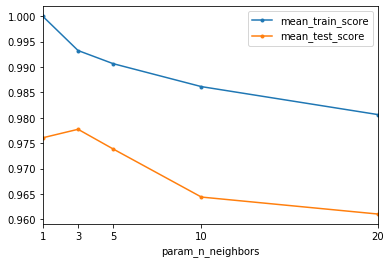

In [8]:
ax = grid_df.plot.line(marker='.')
ax.set_xticks(grid_df.index);

In [9]:
def best_model_hyper_params(make_a_model,
                            some_hyper_params,
                            data):
    results = {}
    for hyper_params in it.combinations(some_hyper_params):
        for train,test in make_cv_split(data):
            model = make_a_model(*hyper_params).fit(train)
            key = tuple(hyper_params)
            if key not in results:
                results[key] = []
            results[key].append(score(test, model.predict(test)))
            # 아니면 위 4줄을 아래와 같이 줄여서 쓸 수도 있습니다.
            # (results.setdefault(tuple(hyper_params), [])
            #         .append(score(test, model.predict(test)))
    
    best_hp = max(results, key=results.get)
    best_model = make_a_model(*best_hp).fit(data)
    return best_model

def do_it():
    model = pick_a_model # 예) kNN

    some_hyper_params = [values_for_hyper_param_1, # 예) n_neighbors=[]
                         values_for_hyper_param_2,
                         values_for_hyper_param_3]

    best_model_hyper_params(model_type, 
                            some_hyper_params, 
                            data)


In [10]:
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_model = skms.GridSearchCV(knn, param_grid = param_grid, cv=10)

In [11]:
# digits 데이터는 제 오래된 노트북에서도 30분 정도밖에 걸리지 않습니다.
# %timeit -r1 grid_model.fit(digits.data, digits.target)
%timeit -r1 grid_model.fit(iris.data, iris.target)

1.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
param_df = pd.DataFrame.from_records(grid_model.cv_results_['params'])
param_df['mean_test_score'] = grid_model.cv_results_['mean_test_score']
param_df.sort_values(by=['mean_test_score']).tail()

,n_neighbors,p,weights,mean_test_score
79,8,16,distance,0.9800
78,8,16,uniform,0.9800
77,8,8,distance,0.9800
88,9,16,uniform,0.9800
99,10,16,distance,0.9800


In [13]:
print("Best Estimator:", grid_model.best_estimator_,
      "Best Score:",     grid_model.best_score_,
      "Best Params:",    grid_model.best_params_, sep="\n")

Best Estimator:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=4,
                     weights='uniform')
Best Score:
0.98
Best Params:
{'n_neighbors': 8, 'p': 4, 'weights': 'uniform'}


In [14]:
import scipy.stats as ss
knn = neighbors.KNeighborsClassifier()
param_dists = {"n_neighbors" : ss.randint(1,11), # [1, 10] 사이의 값
               "weights"     : ['uniform', 'distance'],
               "p"           : ss.geom(p=.5)}

mod = skms.RandomizedSearchCV(knn, 
                              param_distributions = param_dists,
                              cv=10, 
                              n_iter=20) # 뽑아낼 샘플의 개수

# 20개 모델을 적합합니다.
%timeit -r1 mod.fit(iris.data, iris.target)
print(mod.best_score_)

224 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
0.98


In [15]:
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn, 
                             param_grid = param_grid, 
                             iid=False, cv=3)

In [16]:
outer_scores = skms.cross_val_score(grid_knn, 
                                    iris.data, iris.target,
                                    cv=5)
print(outer_scores)

[0.9667 1.     0.9333 0.9667 1.    ]


In [17]:
def nested_cv_pseudo_code(all_data):
    results = []
    for outer_train, test in make_cv_split(all_data):
        for hyper_params in hyper_paramater_possibilities:
            for train, valid in make_cv_split(outer_train):
                inner_score = evaluate(model.fit(train).predict(valid))
        best_mod = xxx # 최고의 inner_score를 기록한 모델을 선택합니다.
        preds = best_model.fit(outer_train).predict(test)
        results.append(evaluate(preds))

In [18]:
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn, 
                             param_grid = param_grid, 
                             iid=False, cv=2)

outer_scores = skms.cross_val_score(grid_knn,
                                    iris.data, 
                                    iris.target,
                                    cv=5)
# 전반적인 성능은 어떨까요?
print(outer_scores)

[0.9667 0.9667 0.9333 0.9667 1.    ]


In [19]:
grid_knn.fit(iris.data, iris.target)
preferred_params = grid_knn.best_estimator_.get_params()
final_knn = neighbors.KNeighborsClassifier(**preferred_params)
final_knn.fit(iris.data, iris.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=4,
                     weights='distance')

In [20]:
scaler = skpre.StandardScaler()
logreg = linear_model.LogisticRegression()

pipe = pipeline.make_pipeline(scaler, logreg)
print(skms.cross_val_score(pipe, iris.data, iris.target, cv=10))

[0.8    0.8667 1.     0.8667 0.9333 0.9333 0.8    0.8667 0.9333 1.    ]


In [21]:
def extract_name(obj):
    return str(logreg.__class__).split('.')[-1][:-2].lower() 

print(logreg.__class__)
print(extract_name(logreg))

<class 'sklearn.linear_model.logistic.LogisticRegression'>
logisticregression


In [22]:
pipe.named_steps.keys()

dict_keys(['standardscaler', 'logisticregression'])

In [23]:
pipe = pipeline.Pipeline(steps=[('scaler', scaler),
                                ('knn', knn)])

cv_scores = skms.cross_val_score(pipe, iris.data, iris.target, 
                                 cv=10, 
                                 n_jobs=-1) # all CPUs
print(pipe.named_steps.keys())
print(cv_scores)

dict_keys(['scaler', 'knn'])
[1.     0.9333 1.     0.9333 0.8667 0.9333 0.8667 1.     1.     1.    ]


In [24]:
from sklearn.base import TransformerMixin
class Median_Big_Small(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, ftrs, tgt=None):
        self.medians = np.median(ftrs)
        return self
    def transform(self, ftrs, tgt=None):
        return ftrs > self.medians

In [25]:
scaler = skpre.StandardScaler()
quad_inters = skpre.PolynomialFeatures(degree=2,              
                                       interaction_only=True, 
                                       include_bias=False)
median_big_small = Median_Big_Small()
knn = neighbors.KNeighborsClassifier()

pipe = pipeline.Pipeline(steps=[('scaler', scaler),
                                ('inter',  quad_inters),
                                ('mbs',    median_big_small),
                                ('knn',    knn)])

cv_scores = skms.cross_val_score(pipe, iris.data, iris.target, cv=10)

print(cv_scores)

[0.6    0.7333 0.8667 0.7333 0.8667 0.7333 0.6667 0.6667 0.8    0.8   ]


In [26]:
# 파이프라인 컴포넌트와 파이프라인을 만듭니다.
scaler = skpre.StandardScaler()
poly   = skpre.PolynomialFeatures()
lasso  = linear_model.Lasso(selection='random', tol=.01)
pipe = pipeline.make_pipeline(scaler, 
                              poly, 
                              lasso)

In [27]:
# 비교할 하이퍼 파라미터들을 설정합니다.
param_grid = {"polynomialfeatures__degree" : np.arange(2,6),
              "lasso__alpha" : np.logspace(1,6,6,base=2)}

from pprint import pprint as pp
pp(param_grid)

{'lasso__alpha': array([ 2.,  4.,  8., 16., 32., 64.]),
 'polynomialfeatures__degree': array([2, 3, 4, 5])}


In [28]:
# 경고를 끄기 위해서 iid를 설정합니다.
mod = skms.GridSearchCV(pipe, param_grid, iid=False, n_jobs=-1)
mod.fit(diabetes.data, diabetes.target);

In [29]:
for name, step in mod.best_estimator_.named_steps.items():
    print("Step:", name)
    print(textwrap.indent(textwrap.fill(str(step), 50), " " * 6))

Step: standardscaler
      StandardScaler(copy=True, with_mean=True,
      with_std=True)
Step: polynomialfeatures
      PolynomialFeatures(degree=2, include_bias=True,
      interaction_only=False,
      order='C')
Step: lasso
      Lasso(alpha=4.0, copy_X=True, fit_intercept=True,
      max_iter=1000,       normalize=False,
      positive=False, precompute=False,
      random_state=None,       selection='random',
      tol=0.01, warm_start=False)


In [30]:
pp(mod.best_params_)

{'lasso__alpha': 4.0, 'polynomialfeatures__degree': 2}
